# Introduction to xarray 

#### presented by Ruth Moorman, Thursday 13th July 2023 (SURF student tutorial) 
#### adapted using ESE101 "Earth's Atmosphere" (2020) recitation by Dave Bonan, Jordan Benjamin, and Tapio Schneider

This tutorial uses output from a state-of-the-art climate model ([CESM2](http://www.cesm.ucar.edu/models/cesm2/)).

In addition to what we cover here I would also recommend this ["xarray in 45 min" tutorial](https://tutorial.xarray.dev/overview/xarray-in-45-min.html), which covers a lot of the basics and which I take material from here, I just wanted to use more visibly Earth-like data for this demonstration. This is all really just to get you started, xarray is **very** well documented and there's load of great resources on their pages so I recommend using them! I would, in particular, recommend these sections on [working with timeseries data](https://docs.xarray.dev/en/stable/user-guide/time-series.html) and [working with weather and climate data](https://docs.xarray.dev/en/stable/user-guide/weather-climate.html), they bring together useful tools nicely. There are also some really useful xarray sections in [Ryan Abernathey's course notes](https://earth-env-data-science.github.io/intro.html).

In [1]:
## PLOTTING PACKAGES
import matplotlib as mpl        # Python's default plotting package https://matplotlib.org/
import matplotlib.pyplot as plt 
from matplotlib import rc, rcParams
rc('font', family = 'serif')
rcParams["text.usetex"]=True
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20) 
rc('axes', labelsize=20)
import cartopy.crs as ccrs      # Mapping  package https://scitools.org.uk/cartopy/docs/latest/

## ANALYSIS PACKAGES
import numpy as np              # Python's numerical and array calculations package https://numpy.org/
import xarray as xr             # Python package for labeled datasets and arrays

In this notebook the key functions we'll cover are:

• `.sel()`
• `.interp()`
• `.groupby()`
• `.wh()`



## Loading a "Dataset" (and the "DataArrays", "Coordinates", "Dimensions", and "Attributes" within it ...)

Below, for reference, is a example of what sorts of information can be included in an xarray Dataset as extracted from a [netCDF](https://www.unidata.ucar.edu/software/netcdf/) file type. 


<p align="center">
  <img width="900" height="300" src="https://docs.xarray.dev/en/stable/_images/dataset-diagram.png">
</p>

Let's explore this file structure in our example netCDF file. 



In [2]:
ds = xr.open_dataset('CESM2_example_data.nc') # load the dataset from a netCDF file
ds                                               # examine the dataset

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 192, lon: 288, plev: 19, time: 12)
Coordinates:
  * time      (time) object 2010-01-15 12:00:00 ... 2010-12-15 12:00:00
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * plev      (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
Dimensions without coordinates: bnds
Data variables:
    tas       (time, lat, lon) float32 ...
    ta        (time, plev, lat, lon) float32 ...
    lon_bnds  (lon, bnds) float64 ...
    lat_bnds  (lat, bnds) float64 ...
Attributes: (12/44)
    CDI:                    Climate Data Interface version 1.9.7.1 (http://mp...
    history:                Tue Sep 22 16:45:30 2020: cdo -ymonmean /export/d...
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    institution:            National Center for Atmospheric Research
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    ...                     ...
    sub_experiment_id:      none
    branch_time_in_parent:  219000.0
    branch_time_in_child:   674885.0
    branch_method:          standard
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.h...
    CDO:                    Climate Data Operators version 1.9.7.1 (http://mp...

There's a lot of extra information in here, not just the arrays of raw data, that's kind of the whole point! 

Make sure to click on the icons to the right of each Dataset component, they will display either metadata about that component (square icon) or the data itself (cylindrical icon) if the data is in memory (sometimes xarray does "lazy loading" stuff with where only metadata, not array contents, are kept in memory...but I'm not going into that today!).

If we want to extract or point to a particular component of this Dataset, we use the convention `ds.{thing you want in ds}` or `ds["thing you want in ds"]`, for example, to extract just the `tas` variable (a DataArray structure) we can write:

In [3]:
ds["tas"]

<xarray.DataArray 'tas' (time: 12, lat: 192, lon: 288)>
[663552 values with dtype=float32]
Coordinates:
  * time     (time) object 2010-01-15 12:00:00 ... 2010-12-15 12:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes: (12/19)
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas

Note that this doesn't actually show us the values within the array here (part of the lazy loading), so if you want to see what the array within this DataArray structure looks like in a more traditional visualization you can execute `ds["tas"].values()`.

In [4]:
ds["tas"].values

array([[[246.53833, 246.53831, 246.53833, ..., 246.53831, 246.53833,
         246.53833],
        [247.28275, 247.24307, 247.08826, ..., 247.31848, 247.30956,
         247.29736],
        [247.74873, 247.70953, 247.68953, ..., 247.97449, 247.92476,
         247.85715],
        ...,
        [246.30984, 246.3379 , 246.36473, ..., 246.23503, 246.25938,
         246.28297],
        [246.12901, 246.13977, 246.15085, ..., 246.09315, 246.10536,
         246.1175 ],
        [245.87308, 245.87418, 245.8752 , ..., 245.86902, 245.8705 ,
         245.87186]],

       [[236.95557, 236.95554, 236.95558, ..., 236.95554, 236.95554,
         236.95552],
        [237.63248, 237.59052, 237.43251, ..., 237.67442, 237.66481,
         237.65   ],
        [238.219  , 238.1761 , 238.1533 , ..., 238.45702, 238.40405,
         238.33199],
        ...,
        [245.66266, 245.69041, 245.71576, ..., 245.58755, 245.61224,
         245.63565],
        [245.23653, 245.24907, 245.26193, ..., 245.19313, 245.20827,
   

If you were then to re-run the previous cell you would see a preview of the data within the `tas` array since it's now loaded in memory.

## Data indexing and subseting

**The \#1 perk of xarray is that we get to use readable dimension information (e.g. latitude, longitude, pressure, time values) to index and analyse our data.**

Bascially, we don't need to use classical numerical indexing when working with xarray. Instead of, for example, figuring out that the equator is associated with the 20th index along the 0th axis, we can just ask for data at `lat=0`.

You can find a lot more detail on ways to index [here](https://docs.xarray.dev/en/stable/user-guide/indexing.html), but here's a couple of examples using the `.sel()` terminology (with a cheeky preview of `.interp()`). 



Say that we wanted to pull out surface air temperature (`tas`, here) from the equator, i.e. we want data where `lat` is equal to 0.

Now, if we look at the latitude coordinate of our data (e.g. run `ds["lat"]`) we should notice that there is no `lat` value precisely equal to 0. So If we try to pull out a value with that latitude we will run into an error, execute `ds.tas.sel(lat=0)` if you're curious.


Instead we would need to include a `method` for inexact matches, these are the options:

• `None (default)`: only exact matches

• `pad / ffill`: propagate last valid index value forward

• `backfill / bfill`: propagate next valid index value backward

• `nearest`: use nearest valid index value

In [5]:
ds.tas.sel(lat=0,method='ffill') # gives us the latitude prior to zero (-0.4712)

<xarray.DataArray 'tas' (time: 12, lon: 288)>
array([[300.57715, 300.59232, 300.60654, ..., 300.49686, 300.53333, 300.5608 ],
       [301.00607, 301.02072, 301.02136, ..., 300.93707, 300.9656 , 300.98495],
       [301.41086, 301.42337, 301.42447, ..., 301.3351 , 301.36526, 301.39017],
       ...,
       [299.1248 , 299.19684, 299.2948 , ..., 298.93982, 298.99918, 299.0596 ],
       [299.8663 , 299.93353, 300.0086 , ..., 299.69608, 299.74576, 299.7983 ],
       [300.24646, 300.27283, 300.3009 , ..., 300.16483, 300.19388, 300.21838]],
      dtype=float32)
Coordinates:
  * time     (time) object 2010-01-15 12:00:00 ... 2010-12-15 12:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lat      float64 -0.4712
Attributes: (12/19)
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas

In [6]:
ds.tas.sel(lat=0,method='bfill') # gives us the latitude after zero (0.4712)

<xarray.DataArray 'tas' (time: 12, lon: 288)>
array([[300.76273, 300.7826 , 300.79843, ..., 300.6431 , 300.68863, 300.72513],
       [301.13058, 301.15424, 301.16364, ..., 301.01932, 301.06366, 301.1    ],
       [301.47397, 301.48544, 301.48355, ..., 301.39456, 301.4264 , 301.45087],
       ...,
       [299.3273 , 299.38492, 299.474  , ..., 299.1795 , 299.22824, 299.27704],
       [300.02307, 300.06702, 300.12915, ..., 299.90198, 299.94193, 299.9799 ],
       [300.3659 , 300.39108, 300.41968, ..., 300.29724, 300.32602, 300.34738]],
      dtype=float32)
Coordinates:
  * time     (time) object 2010-01-15 12:00:00 ... 2010-12-15 12:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lat      float64 0.4712
Attributes: (12/19)
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas

Or we could start getting fancy and interpolate our data to the equator using the [`.interp()` function](https://docs.xarray.dev/en/stable/user-guide/interpolation.html).

In [7]:
ds.tas.interp(lat=0, method='linear')

<xarray.DataArray 'tas' (time: 12, lon: 288)>
array([[300.66993713, 300.68745422, 300.70248413, ..., 300.56997681,
        300.61097717, 300.64295959],
       [301.06832886, 301.08747864, 301.09249878, ..., 300.97819519,
        301.01463318, 301.04248047],
       [301.44241333, 301.45440674, 301.45401001, ..., 301.36483765,
        301.39582825, 301.42051697],
       ...,
       [299.2260437 , 299.2908783 , 299.38439941, ..., 299.05966187,
        299.1137085 , 299.1683197 ],
       [299.94468689, 300.00027466, 300.06887817, ..., 299.79902649,
        299.84384155, 299.88909912],
       [300.30618286, 300.33195496, 300.36029053, ..., 300.23103333,
        300.25994873, 300.28288269]])
Coordinates:
  * time     (time) object 2010-01-15 12:00:00 ... 2010-12-15 12:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lat      int64 0
Attributes: (12/19)
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas

Another very common action would be to index according to a range, e.g. we may only want Southern Hemisphere data (sensibly, as it is the hemisphere with Australia in it).

In [8]:
ds.tas.sel(lat=slice(None,0)) # gives data with latitude values between the lower limit (None, could equivalently say -90) and the equator (0)

<xarray.DataArray 'tas' (time: 12, lat: 96, lon: 288)>
array([[[246.53833, 246.53831, ..., 246.53833, 246.53833],
        [247.28275, 247.24307, ..., 247.30956, 247.29736],
        ...,
        [300.4824 , 300.49835, ..., 300.4463 , 300.4655 ],
        [300.57715, 300.59232, ..., 300.53333, 300.5608 ]],

       [[236.95557, 236.95554, ..., 236.95554, 236.95552],
        [237.63248, 237.59052, ..., 237.66481, 237.65   ],
        ...,
        [300.9436 , 300.94702, ..., 300.91852, 300.932  ],
        [301.00607, 301.02072, ..., 300.9656 , 300.98495]],

       ...,

       [[234.73273, 234.73273, ..., 234.73273, 234.73273],
        [235.42912, 235.39182, ..., 235.45154, 235.44125],
        ...,
        [299.7156 , 299.78543, ..., 299.59048, 299.64688],
        [299.8663 , 299.93353, ..., 299.74576, 299.7983 ]],

       [[245.43279, 245.43279, ..., 245.43279, 245.43279],
        [246.12546, 246.0862 , ..., 246.15402, 246.14046],
        ...,
        [300.20035, 300.23154, ..., 300.13962, 300.16846],
        [300.24646, 300.27283, ..., 300.19388, 300.21838]]], dtype=float32)
Coordinates:
  * time     (time) object 2010-01-15 12:00:00 ... 2010-12-15 12:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... -2.356 -1.414 -0.4712
Attributes: (12/19)
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas

## Mapping a monthly mean field (where `lat` and `lon` are 1D Dimensions)

Plotting a map of the January temperature field as an example.

In [9]:
jan_field = ds.tas.sel(time='2010-01').squeeze('time')
jan_field

<xarray.DataArray 'tas' (lat: 192, lon: 288)>
array([[246.53833, 246.53831, 246.53833, ..., 246.53831, 246.53833, 246.53833],
       [247.28275, 247.24307, 247.08826, ..., 247.31848, 247.30956, 247.29736],
       [247.74873, 247.70953, 247.68953, ..., 247.97449, 247.92476, 247.85715],
       ...,
       [246.30984, 246.3379 , 246.36473, ..., 246.23503, 246.25938, 246.28297],
       [246.12901, 246.13977, 246.15085, ..., 246.09315, 246.10536, 246.1175 ],
       [245.87308, 245.87418, 245.8752 , ..., 245.86902, 245.8705 , 245.87186]],
      dtype=float32)
Coordinates:
    time     object 2010-01-15 12:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes: (12/19)
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    ...             ...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas

xarray plays well with all the cartopy mapping functions

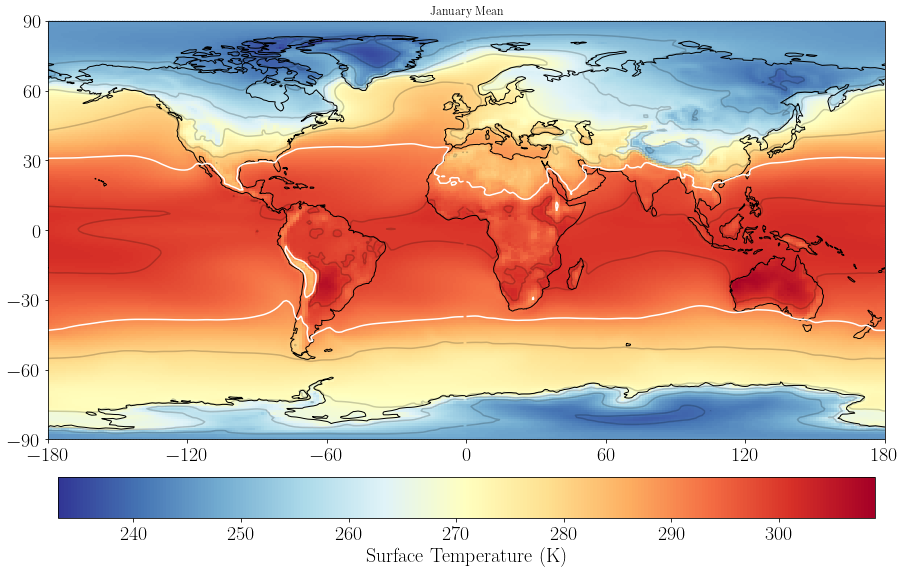

In [10]:
fig = plt.figure(figsize=(15,10))       # initialize a fairly large figure
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global() # show the entire globe
ax.coastlines() # plot coastlines
c = ax.pcolormesh(jan_field.lon,jan_field.lat,jan_field, cmap='RdYlBu_r',transform=ccrs.PlateCarree())
ax.contour(jan_field.lon,jan_field.lat,jan_field,levels=[240,250,260,270,280,300],colors=['k'],alpha=0.2,transform=ccrs.PlateCarree(),vmin=220,vmax=310)
ax.contour(jan_field.lon,jan_field.lat,jan_field,levels=[290],colors=['w'],transform=ccrs.PlateCarree())
ax.set_xticks([-180,-120,-60,0,60,120,180])
ax.set_yticks([-90,-60,-30,0,30,60,90])
ax.set_title('January Mean')
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.07,shrink=0.975) # add colorbar axes at bottom
cbar=plt.colorbar(c,cax = cax,orientation='horizontal')
cbar.set_label('Surface Temperature (K)', fontsize = 20)


## Mapping seasonal mean fields using the `.groupby()` function

`.groupby()` is an incredibly useful function within xarray, there's a detailed overview [here](https://docs.xarray.dev/en/stable/user-guide/groupby.html) but really this is a very flexible function. `.resample()`, `.rolling()` and `.coarsen()` are useful related functions I won't go into here but recommend you checking out. Here we will use `.groupby()` to compute seasonal mean `tas` fields, but essentially it can be used for any situation where you want to bin or cluster data in groups prior to executing a function.

In [11]:
tas_seasons = ds.tas.groupby('time.season').mean() # an example of cool time functionality in xarray
tas_seasons

<xarray.DataArray 'tas' (season: 4, lat: 192, lon: 288)>
array([[[242.97557, 242.97554, 242.97557, ..., 242.97554, 242.97554,
         242.97554],
        [243.68022, 243.63994, 243.48482, ..., 243.71844, 243.70947,
         243.69594],
        [244.1905 , 244.15009, 244.12941, ..., 244.41936, 244.36897,
         244.29988],
        ...,
        [246.89949, 246.92635, 246.95135, ..., 246.82758, 246.85112,
         246.87358],
        [246.58092, 246.59157, 246.60254, ..., 246.54417, 246.55696,
         246.56934],
        [246.27357, 246.2748 , 246.27592, ..., 246.26912, 246.27075,
         246.27223]],

       [[216.44788, 216.44788, 216.44788, ..., 216.44788, 216.44788,
         216.44788],
        [216.72768, 216.70299, 216.55965, ..., 216.71672, 216.72417,
         216.7268 ],
        [217.14531, 217.12675, 217.1295 , ..., 217.31435, 217.28369,
         217.23311],
...
        [256.42697, 256.44275, 256.45755, ..., 256.38544, 256.39853,
         256.4115 ],
        [256.38425, 256.39035, 256.39676, ..., 256.3635 , 256.371  ,
         256.37784],
        [256.3392 , 256.33966, 256.34012, ..., 256.33743, 256.33804,
         256.33865]],

       [[224.41412, 224.41412, 224.41412, ..., 224.41412, 224.41412,
         224.41412],
        [224.9218 , 224.89166, 224.74532, ..., 224.92741, 224.92921,
         224.92639],
        [225.4223 , 225.39445, 225.3877 , ..., 225.61505, 225.57642,
         225.51762],
        ...,
        [261.06866, 261.088  , 261.10648, ..., 261.0168 , 261.03336,
         261.04968],
        [261.0722 , 261.0788 , 261.08572, ..., 261.05078, 261.05826,
         261.0654 ],
        [261.0365 , 261.03702, 261.0375 , ..., 261.03452, 261.03525,
         261.0359 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

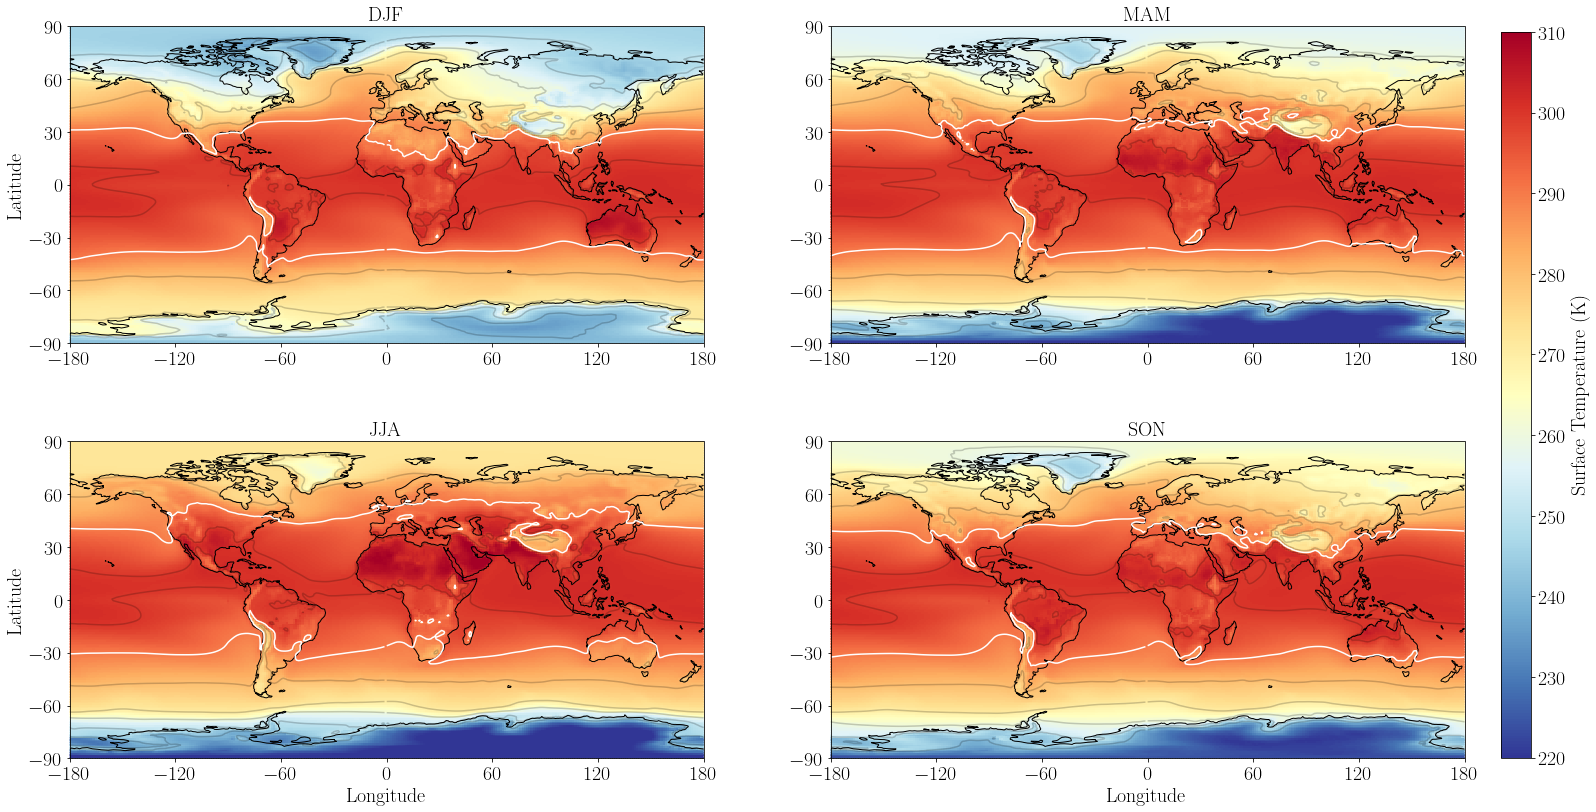

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,14), subplot_kw={'projection': ccrs.PlateCarree()})
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    seas_data = tas_seasons.sel(season=season) # select the season we want
    ax=axes.flatten()[i]                       # specify the axis
    ax.set_title(season, fontsize=20)
    ax.set_global() # show the entire globe
    ax.coastlines() # plot coastlines
    c = ax.pcolormesh(seas_data.lon,seas_data.lat,seas_data, cmap='RdYlBu_r',transform=ccrs.PlateCarree(), vmin=220,vmax=310)
    ax.contour(seas_data.lon,seas_data.lat,seas_data,levels=[240,250,260,270,280,300],colors=['k'],alpha=0.2,transform=ccrs.PlateCarree())
    ax.contour(seas_data.lon,seas_data.lat,seas_data,levels=[290],colors=['w'],transform=ccrs.PlateCarree())
    ax.set_xticks([-180,-120,-60,0,60,120,180])
    ax.set_yticks([-90,-60,-30,0,30,60,90])
    if i in (0,2):
        ax.set_ylabel('Latitude')
    if i in (2,3):
        ax.set_xlabel('Longitude')
cax = fig.add_axes([0.92, 0.14, 0.017, 0.72])
cbar=plt.colorbar(c,cax = cax,orientation='vertical')
cbar.set_label('Surface Temperature (K)', fontsize = 20)
plt.show()

## Weighted spatial means using `.weighted()`

Say we want to look at a global mean vertical profile of temperature using the `tas` variable. Because the earth is spherical, data points as high latitudes describe less area than data points at low latitudes. The proper latitude ($\phi$) weighting is:
$$\text{weight} = \cos(\phi) $$
If we do not weight correctly, we may overreppresent high latitude areas that are cold but take up little area, decreasing the global-mean temperature. See [this example](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html).

Xarray can perform the weighting nearly automatically with the [`.weighted()` function](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.weighted.html):

In [13]:
weight = np.cos(np.deg2rad(ds.ta['lat']))    # convert degrees to radians and calculate the weights using the full xarray lat object. Using the full ojbect and all its metadata is impoprtant!

In [14]:
temperature_weighted = ds['ta'].weighted(weight)                          # calculate a weighted mean object in xarray ()
plot_data  = temperature_weighted.mean(['lat','lon','time']).transpose()  # take the mean over latitude, longitude, and time leaving only a vertical profile

We could do this manually as well, the definition of a weighted mean is:
$$ \left<x\right>_w = \frac{\sum w_i x_i}{\sum w_i} = \sum x_i \frac{ w_i }{\sum w_i}$$
so we would need to calculate the following:
$$ \left<x\right>_w = x_i \frac{ w_i }{\sum w_i} $$
and sum over latitude. <br>

One might be tempted to do the following:

In [15]:
wi_sumwi = weight/weight.sum('lat')                                                 # compute the normalised weights term above
plot_data_1   = (ds['ta'] * wi_sumwi).sum(['lat']).mean(['lon','time']).transpose() # for latitude, we only have the sum as described above, and then a mean over lat and time to leave a vertical profile

But this is actually incorrect as it includes weights for data points where there is no temperature values recorded (when the surface pressure is higher than the lower limit of the y-axis). If we wanted to do this manually (i.e. not using the `.weighted()` function) we would need to remove weights where temperature data does not exist. This can be done by, for example, expanding the weights array to 2 dimensions and masking out wherever no `ta` data is available. 

In [16]:
weight_masked = ds['ta']*0+weight                        # note ds["ta"]*0 is a mask of 0 where ta data exists and NaN where ta data is absent
wi_sumwi_masked = weight_masked/weight_masked.sum('lat') # compute the normalised weights term above excluding regions with no data
plot_data_2   = (ds['ta'] * wi_sumwi_masked).sum(['lat']).mean(['lon','time']).transpose() # for latitude, we only have the sum as described above, and then a mean over lat and time to leave a vertical profile

And we can compare these options to an unweighted mean.

In [17]:
plot_data_3   = ds["ta"].mean(['lat','lon','time']).transpose() # simple mean (incorrect)

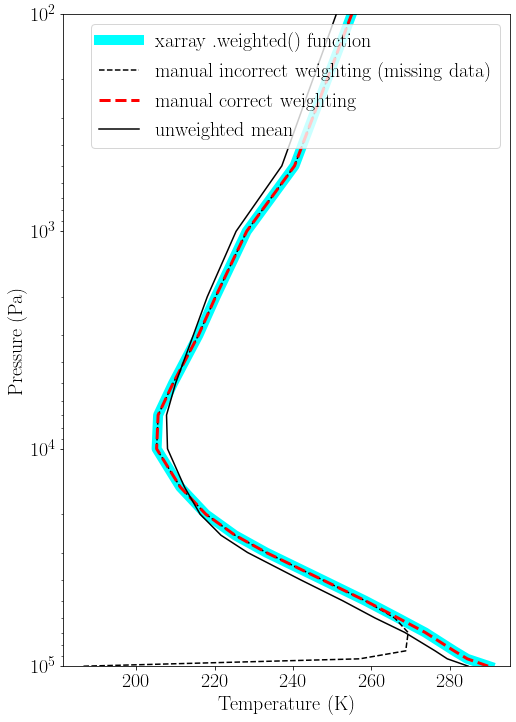

In [18]:
fig = plt.figure(figsize=(8, 12)) # assign a vertically tall figure
ax  = plt.axes()                  # assign axes to the figure

plot_data.plot(  ax=ax, y='plev',yscale='log',ylim=[plot_data.plev.max()  ,plot_data.plev.min()  ],linewidth=10,              color='cyan' , label='xarray .weighted() function'  ) # plot profile, log scale, width 10, color cyan,  label as xarray
plot_data_1.plot(ax=ax, y='plev',yscale='log',ylim=[plot_data_2.plev.max(),plot_data_2.plev.min()],linestyle='--',             color='black', label='manual incorrect weighting (missing data)') # plot profile, log scale,           color black, label as method 1
plot_data_2.plot(ax=ax, y='plev',yscale='log',ylim=[plot_data_2.plev.max(),plot_data_2.plev.min()],linestyle='--', linewidth=3 ,color='red', label='manual correct weighting') # plot profile, log scale,           color black, label as method 1
plot_data_3.plot(ax=ax, y='plev',yscale='log',ylim=[plot_data_2.plev.max(),plot_data_2.plev.min()],                           color='black', label='unweighted mean') # plot profile, log scale,           color black, label as method 1
ax.set_xlabel('Temperature (K)');ax.set_ylabel('Pressure (Pa)')
_ = ax.legend(fontsize=20) # you see the problems at the bottom from some missing data

We can also check if weighting by the length of each month makes a difference...

In [19]:
weight_time = ds['time.days_in_month'] # another example of cool time functionality
weight_time

<xarray.DataArray 'days_in_month' (time: 12)>
array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
Coordinates:
  * time     (time) object 2010-01-15 12:00:00 ... 2010-12-15 12:00:00

In [20]:
temperature_spatial_weighted = ds['ta'].weighted(weight)                        # calculate a weighted mean object in xarray ()
temperature_spatial_weighted_mean  = temperature_spatial_weighted.mean(['lat','lon']) 
temperature_time_weighted = temperature_spatial_weighted_mean.weighted(weight_time)
plot_data_4  = temperature_time_weighted.mean(['time']).transpose()  # take the mean over latitude, longitude, and time leaving only a vertical profile

In [21]:
(plot_data_4 - plot_data).values # comparatively very small errors, may matter in some cases though!

array([ 0.0162723 ,  0.00845041,  0.0073985 ,  0.00595231,  0.0049605 ,
        0.00475147,  0.0039741 ,  0.0016369 , -0.00089514, -0.004297  ,
       -0.00478616, -0.00020616,  0.00518476,  0.00312387, -0.0018438 ,
       -0.00415395, -0.00739367, -0.008134  , -0.0078376 ])

## Masking using the `.where()` function

The xarray [`.where()` function](https://docs.xarray.dev/en/stable/generated/xarray.where.html) is another useful one and it's use comes up in a couple of contexts. A couple that come to mind include (i) creating a mask based on some critereon, (ii) removing outliers from a dataset, and (iii) selecting a subset from your dataset based off a coordinate that is not a dimension (e.g. if you have irregular 2D latitude and longitude fields but want to subset by latitude).

As a simple example here, let's just repeat our previous map plot but exclude temperature values below 290 K (white contour previously).

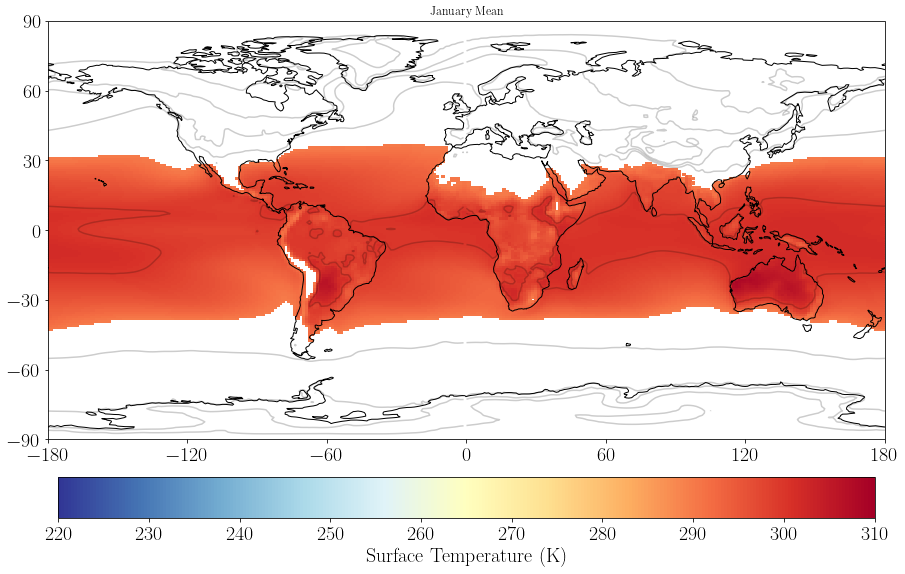

In [22]:
fig = plt.figure(figsize=(15,10))       # initialize a fairly large figure
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global() # show the entire globe
ax.coastlines() # plot coastlines

## change is here
c = ax.pcolormesh(jan_field.lon,jan_field.lat,jan_field.where(jan_field>290), cmap='RdYlBu_r',transform=ccrs.PlateCarree(),vmin=220,vmax=310) 

ax.contour(jan_field.lon,jan_field.lat,jan_field,levels=[240,250,260,270,280,300],colors=['k'],alpha=0.2,transform=ccrs.PlateCarree())
ax.set_xticks([-180,-120,-60,0,60,120,180])
ax.set_yticks([-90,-60,-30,0,30,60,90])
ax.set_title('January Mean')
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.07,shrink=0.975) # add colorbar axes at bottom
cbar=plt.colorbar(c,cax = cax,orientation='horizontal')
cbar.set_label('Surface Temperature (K)', fontsize = 20)


## Mapping a field (where `lat` and `lon` are 2D Coordinates)

**a brief interlude with another data file**

You may run into circumstances where the spatial information of your data are actually 2 dimensional themselves! Many general circulation models have irregular (w.r.t latitude and longitude) grids and yet you may still want to plot maps with latitude and longtiude axes (or do other operations along these coordinates). Here's a quick example of how you can use 2 dimensional coordinate data, using some bathymetry from a regional ocean model I personally use.

In [23]:
bathy = xr.open_dataset('bathy.nc')
bathy

<xarray.Dataset>
Dimensions:  (XC: 1240, YC: 600)
Coordinates:
  * YC       (YC) int64 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599
  * XC       (XC) int64 0 1 2 3 4 5 6 7 ... 1233 1234 1235 1236 1237 1238 1239
    LONC     (YC, XC) float32 ...
    LATC     (YC, XC) float32 ...
Data variables:
    bathy    (YC, XC) float32 ...

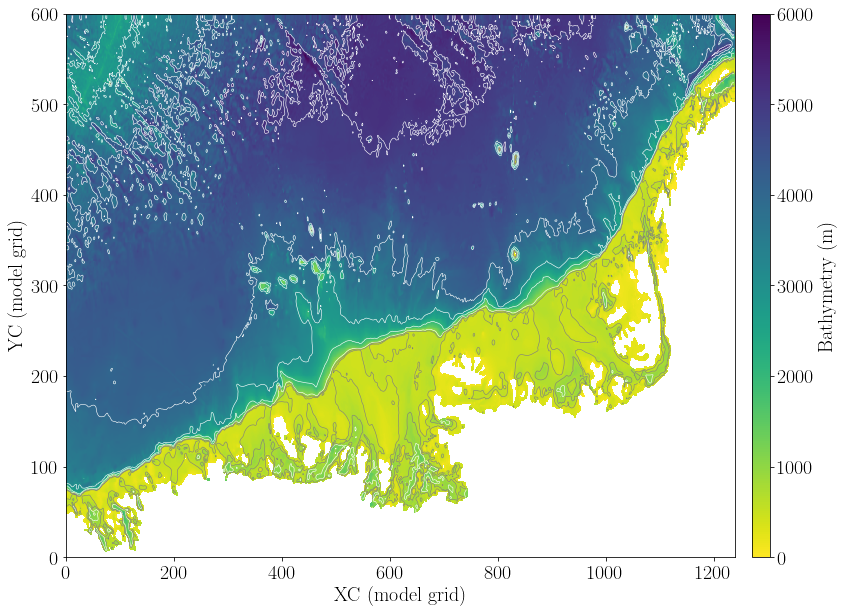

In [24]:
fig, (ax) = plt.subplots(1, 1, figsize=(12,10))
# bathy shading
c = ax.pcolormesh(-bathy.bathy, cmap='viridis_r', vmax=6000, vmin=0)
# bathy contours
ax.contour(-bathy.bathy, levels = [1000,2000,3000,4000,5000], colors=['white'], linewidths=0.6)
ax.contour(-bathy.bathy, levels = [500,750], colors=['grey'], linewidths=0.6)

# axis labels
ax.set_xlabel('XC (model grid)')
ax.set_ylabel('YC (model grid)')
cax = fig.add_axes([0.92, 0.125, 0.02, 0.755])
cbar=plt.colorbar(c,cax = cax,orientation='vertical')
cbar.set_label('Bathymetry (m)', fontsize = 20)

plt.show()

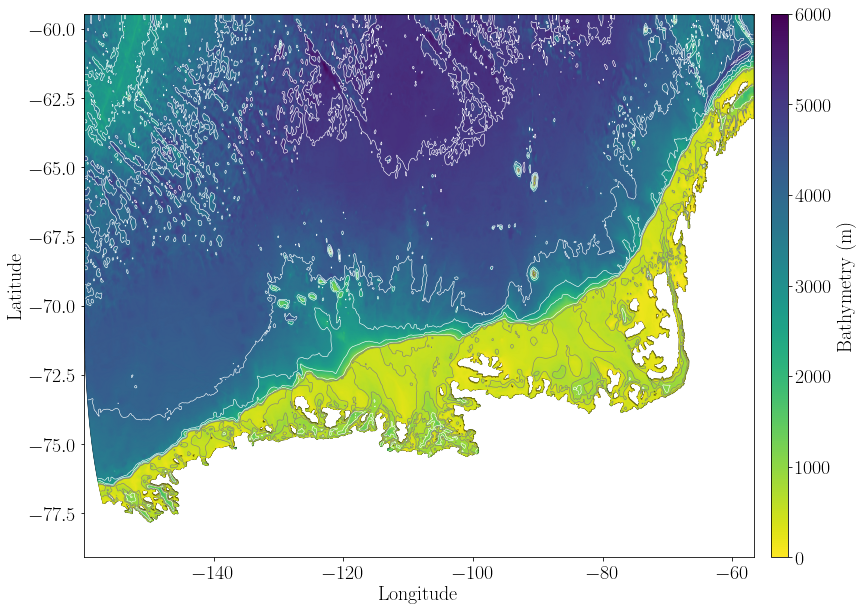

In [25]:
fig, (ax) = plt.subplots(1, 1, figsize=(12,10))

# bathy shading
c = ax.pcolormesh(bathy.LONC, bathy.LATC,-bathy.bathy, cmap='viridis_r', vmax=6000, vmin=0, shading='gouraud')
# # bathy contours
ax.contour(bathy.LONC, bathy.LATC,-bathy.bathy, levels = [1000,2000,3000,4000,5000], colors=['white'], linewidths=0.6)
ax.contour(bathy.LONC, bathy.LATC,-bathy.bathy, levels = [500,750], colors=['grey'], linewidths=0.6)

# axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
cax = fig.add_axes([0.92, 0.125, 0.02, 0.755])
cbar=plt.colorbar(c,cax = cax,orientation='vertical')
cbar.set_label('Bathymetry (m)', fontsize = 20)

plt.show()